# Reproducing MacFall 2019

In [1]:
import numpy as np
from numpy import linalg
import torch
from torch import nn
from custombc import Point, DirichletControlPoint, CustomDirichletBoundaryCondition
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

## Example Problem A

<img src="problem-a.png" alt="drawing" width="500"/>

In [2]:
def solution_analytical_problem_a(x, y):
    return np.exp(-x)*(x+y**3)

In [3]:
control_points_problem_a = []
points_on_each_edge = 41
# psi(0, y) = y^3
for point_y in np.linspace(0.0, 1.0, points_on_each_edge):
    point_x = 0.0
    psi = point_y**3
    control_points_problem_a.append(
        DirichletControlPoint(loc=(point_x, point_y), val=psi)
    )
# psi(1, y) = (1+y^3)/e
for point_y in np.linspace(0.0, 1.0, points_on_each_edge):
    point_x = 1.0
    psi = (1+point_y**3)/np.e
    control_points_problem_a.append(
        DirichletControlPoint(loc=(point_x, point_y), val=psi)
    )
# psi(x, 0) = xe^(-x)
for point_x in np.linspace(0.0, 1.0, points_on_each_edge):
    point_y = 0.0
    psi = point_x*np.exp(-point_x)
    control_points_problem_a.append(
        DirichletControlPoint(loc=(point_x, point_y), val=psi)
    )
# psi(x, 1) = (e^(-x))(1+x)
for point_x in np.linspace(0.0, 1.0, points_on_each_edge):
    point_y = 1.0
    psi = np.exp(-point_x) * (1+point_x)
    control_points_problem_a.append(
        DirichletControlPoint(loc=(point_x, point_y), val=psi)
    )
cdbc_problem_a = CustomDirichletBoundaryCondition( 
    control_points_problem_a, 
    center_point=Point((0.5, 0.5)) 
)

In [4]:
# parameters are according to table 1
# original paper used the 'healed topographical multilevel single linkage global optimization scheme 
# with the Lev- enberg–Marquardt gradient-descent method as the local search technique' (???)
# here use Adams instead. also assume batch size = size of the training set
# original paper used sigmoid activationm here use softplus instead.

# nabla^2 psi(x, y) = (e^(-x))(x-2+y^3+6y)
def de_problem_a(u, x, y):
    return diff(u, x, order=2) + diff(u, y, order=2) - torch.exp(-x) * (x - 2 + y**3 + 6*y)

# fully connected network with one hidden layer (35 hidden units with softplus activation)
net = FCNN(n_input_units=2, n_hidden_units=35, n_hidden_layers=1, actv=nn.Sigmoid)

# train on 28 X 28 grid
solution_neural_net_problem_a, history_problem_a = solve2D(
    pde=de_problem_a, condition= cdbc_problem_a,
    xy_min=(0, 0), xy_max=(1, 1),
    train_generator=ExampleGenerator2D(
        (28, 28), (0, 0), (1, 1), method='equally-spaced'
    ),
    net=net, max_epochs=10000, batch_size=784
)

In [5]:
with open('solution-problem-a', 'wb') as pickle_file:
    pickle.dump(solution_neural_net_problem_a, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('history-problem-a', 'wb') as pickle_file:
    pickle.dump(history_problem_a, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('solution-problem-a', 'rb') as pickle_file:
    solution_neural_net_problem_a = pickle.load(pickle_file)
with open('history-problem-a', 'rb') as pickle_file:
    history_problem_a = pickle.load(pickle_file)

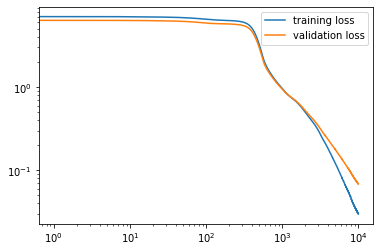

In [7]:
plt.loglog(history_problem_a['train'], label='training loss')
plt.loglog(history_problem_a['valid'], label='validation loss')
plt.legend();

<img src="evaluation.png" alt="drawing" width="500"/>

In [8]:
def get_grid(x_from_to, y_from_to, x_n_points=100, y_n_points=100, as_tensor=False):
    x_from, x_to = x_from_to
    y_from, y_to = y_from_to
    if as_tensor:
        x = torch.linspace(x_from, x_to, x_n_points)
        y = torch.linspace(y_from, y_to, y_n_points)
        return torch.meshgrid(x, y)
    else:
        x = np.linspace(x_from, x_to, x_n_points)
        y = np.linspace(y_from, y_to, y_n_points)
        return np.meshgrid(x, y)

def compare_contour(sol_net, sol_ana, eval_on_xs, eval_on_ys):
    s_net = sol_net(eval_on_xs, eval_on_ys, as_type='np')
    s_ana = sol_ana(eval_on_xs, eval_on_ys)
    
    fig = plt.figure(figsize=(18, 4))

    ax1 = fig.add_subplot(131)
    cs1 = ax1.contourf(eval_on_xs, eval_on_ys, s_net, cmap='coolwarm')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)

    ax2 = fig.add_subplot(132)
    cs2 = ax2.contourf(eval_on_xs, eval_on_ys, s_ana, cmap='coolwarm')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

    ax3 = fig.add_subplot(133)
    cs3 = ax3.contourf(eval_on_xs, eval_on_ys, s_net-s_ana, cmap='coolwarm')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)
    
def relative_error_norm(sol_net, sol_ana, eval_on_xs, eval_on_ys):
    s_net = sol_net(eval_on_xs, eval_on_ys, as_type='np')
    s_ana = sol_ana(eval_on_xs, eval_on_ys)
    return linalg.norm(s_net-s_ana) / linalg.norm(s_ana)

In [9]:
xx_train, yy_train = get_grid(
    x_from_to=(0, 1), y_from_to=(0, 1), 
    x_n_points=28, y_n_points=28
)
xx_valid, yy_valid = get_grid(
    x_from_to=(0, 1), y_from_to=(0, 1), 
    x_n_points=100, y_n_points=100
)

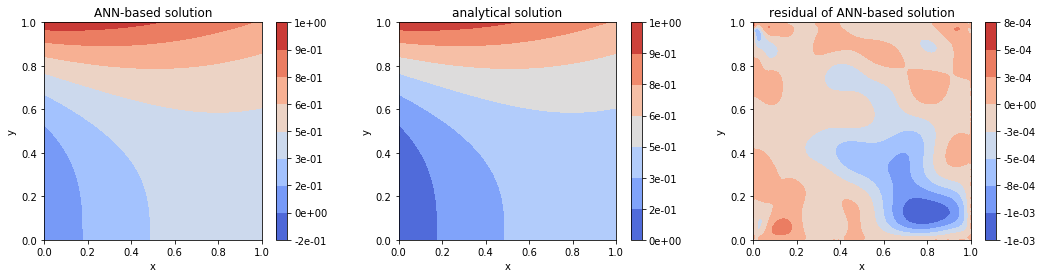

In [10]:
compare_contour(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_valid, yy_valid
)

In [11]:
relative_error_norm(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_train, yy_train
)

0.0007115471850994183

In [12]:
relative_error_norm(
    solution_neural_net_problem_a, 
    solution_analytical_problem_a,
    xx_valid, yy_valid
)

0.0007405495907166547